In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

long_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
long_df = long_df[keep_syllables]
long_df=filter_df(long_df)
long_df = long_df.query('age<100')

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df = male_df.query('age<100')

In [7]:
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)

# use only common ages
long_ages = long_df.index.get_level_values('age').unique().to_numpy()
m_ages = male_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(long_ages,m_ages))
male_df = male_df.loc[male_df.index.get_level_values('age').isin(cages)]
male_df['exp'] = 'ont'
male_df.set_index('exp',inplace=True,append=True)

long_df = long_df.loc[long_df.index.get_level_values('age').isin(cages)]
long_df['exp'] = 'long'
long_df.set_index('exp',inplace=True,append=True)

In [8]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# avarage per age or session
l_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_l_df = l_df.groupby(['age']).mean()
# normalize the data
l_norm = mm_norm_col(l_df)
avg_l_norm = mm_norm_col(avg_l_df)

In [9]:
m_data = m_norm.copy()
long_data = l_norm.copy()

In [10]:
## MI for age in ontogeny

In [11]:
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_ont = MIR(X,y)

In [12]:
ont_indx = np.argsort(mi_score_ont)[::-1][0:len(keep_syllables)] # syllble index
impsyl_ont= list(m_data.columns[ont_indx]) #syllable id
top_mi_score_ont = mi_score_ont[ont_indx]
imp_ont = np.array(['n']*len(mi_score_ont))
imp_ont[np.array(ont_indx)]='y'

In [13]:
print('10 most informative syllables for ontogeny: ',impsyl_ont)

10 most informative syllables for ontogeny:  [12, 42, 69, 62, 90, 49, 50, 4, 74, 97, 5, 11, 79, 25, 85, 9, 52, 83, 30, 59, 53, 10, 7, 60, 23, 98, 41, 61, 77, 6, 14, 70, 2, 32, 33, 24, 63, 13, 73, 16, 71, 67, 36, 55, 64, 44, 84, 39, 68, 27, 0, 95, 76, 18, 93, 17, 66, 54]


In [14]:
## MI for age in longtogeny

In [15]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_long = MIR(X,y)

In [16]:
long_indx = np.argsort(mi_score_long)[::-1][0:len(keep_syllables)] # syllble index
impsyl_long= list(long_data.columns[long_indx]) #syllable id
top_mi_score_long = mi_score_long[long_indx]
imp_long = np.array(['n']*len(mi_score_long))
imp_long[np.array(long_indx)]='y'

In [17]:
print('10 most informative syllables for ontogeny: ',impsyl_long)

10 most informative syllables for ontogeny:  [50, 42, 18, 62, 23, 97, 25, 5, 79, 4, 6, 13, 69, 12, 83, 77, 63, 32, 76, 74, 71, 16, 90, 30, 67, 39, 70, 11, 33, 36, 44, 9, 64, 55, 2, 84, 98, 52, 59, 68, 73, 85, 27, 41, 14, 10, 54, 24, 53, 17, 66, 60, 7, 61, 49, 93, 0, 95]


In [18]:
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_ont,mi_score_long))
mi_df['syll'] = np.concatenate((np.array(m_data.columns),np.array(long_data.columns)))
#mi_df['rank']  = np.concatenate((np.array(impsyl_ont),np.array(impsyl_long)))
mi_df['exp'] = ['ont']*len(m_data.columns)+['long']*len(long_data.columns)

In [19]:
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()

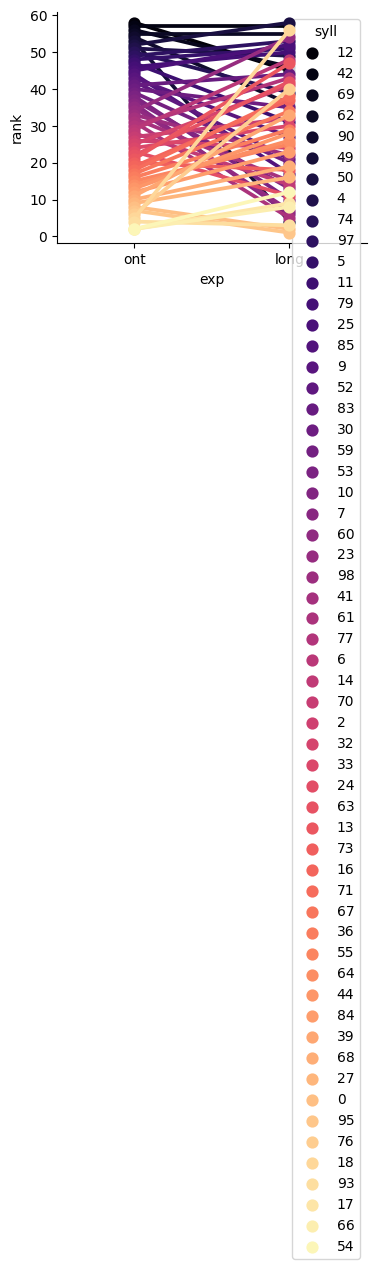

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True,palette='magma',hue_order=impsyl_ont)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'lvo_syll_MI_aging_rank.pdf')